In [1]:
import pandas as pd
import numpy as np
import math
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.externals import joblib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 15]

In [2]:
#read trips data and join it with weather and public holidays dataset
trips = pd.read_csv('../data/modelInput/flowPerHourAndCluster.csv')
additional_features = pd.read_csv('../data/modelInput/additionalFeatures.csv')
trips = trips.merge(additional_features, how='left', on=('date_hour'))
del additional_features
trips['date_hour'] = trips['date_hour'].apply(pd.Timestamp) 
trips = trips.set_index('date_hour')

In [3]:
trips.columns

Index(['cluster_id', 'arrivals', 'departures', 'apparentTemperature',
       'cloudCover', 'dewPoint', 'humidity', 'icon', 'precipAccumulation',
       'precipIntensity', 'precipProbability', 'precipType', 'pressure',
       'summary', 'temperature', 'uvIndex', 'visibility', 'windBearing',
       'windSpeed', 'date', 'hour', 'weekday', 'month', 'year',
       'holiday_description', 'is_holiday', 'is_weekend',
       'is_weekend_or_holiday'],
      dtype='object')

In [4]:
features = ['cluster_id',
            'apparentTemperature', 'cloudCover',
            'dewPoint', 'humidity', 'precipIntensity',
            'precipProbability', 'pressure', 'temperature',
            'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'hour',
            'weekday', 'is_holiday', 'is_weekend', 'is_weekend_or_holiday']

#For parameter optimization, we create a reduced dataset from the 10 clusters
#with highest sum-of-weights; these are the central clusters.
cluster_model = joblib.load('../models/gaussianMixtureModel.pkl')
cluster_selection = np.argsort(-cluster_model.weights_)[:10]
reduced_trips = trips[trips['cluster_id'].isin(cluster_selection)]

#Split the dataset at 2016-5-1 into training and test data 
test_begin_date = pd.Timestamp(2016, 5, 1)

#We do cross-validation for the reduced dataset of 10 clusters.
#The test period starting from 2016-5-1 is not used for parameter optimization. 
X_train_reduced = reduced_trips[:test_begin_date][features]
y_train_reduced = reduced_trips[:test_begin_date]['departures']
X_train_reduced, y_train_reduced = shuffle(X_train_reduced, y_train_reduced, random_state=42)

#Create the trainig and test data for the final model.
X_train = trips[:test_begin_date][features]
X_test = trips[test_begin_date:][features]
y_train = trips[:test_begin_date]['departures']
y_test = trips[test_begin_date:]['departures']

X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print('Training set size: ', X_train.shape[0])
print('Test set size: ', X_test.shape[0])
print('Reduced training set size: ', X_train_reduced.shape[0])

Training set size:  439250
Test set size:  256800
Reduced training set size:  87850


In [5]:
#Creates a XGBoost model from the parameters given in the sklearn wrapper.
def train_XGBModel(model, X_train, y_train, X_test, y_test, learning_rate=.005):
    #get parameters from slearn wrapper
    xgb_param = model.get_xgb_params()
    
    #set parameters for native XGBoost
    xgb_param['eval_metric'] = 'rmse'
    xgb_param['learning_rate'] = learning_rate
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    booster = xgb.train(xgb_param,
                        dtrain,
                        num_boost_round=100000,
                        evals=watchlist,
                        early_stopping_rounds=100,
                        verbose_eval=500)
    return booster

In [6]:
#Number of parallel jobs
n_jobs=16

#Cross-validation fold number
cv_folds=5

#MSE scorer for cross-validation
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

#Grid search for given sklearn wrapper and parameters
def grid_search(model, parameters, X_train, y_train):
    gsearch = GridSearchCV(estimator=model, 
                           param_grid=parameters,
                           scoring=mse_scorer,
                           cv=cv_folds, 
                           n_jobs=n_jobs,
                           verbose=2)
    gsearch.fit(X_train, y_train)
    print('Best parameters: ', gsearch.best_params_)
    print('Best score: ', gsearch.best_score_)
    
    #return the best model
    return gsearch.best_estimator_

In [7]:
#sklearn wrapper for XGBoost with initial parameters 
basic_model = XGBRegressor(
    booster='gbtree',
    learning_rate=0.1,
    gamma=0,
    max_depth=3,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8, 
    reg_lambda=1,
    reg_alpha=0,
    scale_pos_weight=1,
    objective='count:poisson',
    nthread=16,
    seed=42)

#Evaluate the performance of an XGBooster based on the initial parameters
basic_xgb = train_XGBModel(basic_model, X_train, y_train, X_test, y_test, .005)

[0]	train-rmse:7.22631	valid-rmse:9.26289
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:5.51874	valid-rmse:7.08478
[1000]	train-rmse:4.85297	valid-rmse:6.23422
[1500]	train-rmse:4.36952	valid-rmse:5.62544
[2000]	train-rmse:4.05847	valid-rmse:5.23482
[2500]	train-rmse:3.80802	valid-rmse:4.91804
[3000]	train-rmse:3.61594	valid-rmse:4.67426
[3500]	train-rmse:3.46971	valid-rmse:4.48916
[4000]	train-rmse:3.35456	valid-rmse:4.34615
[4500]	train-rmse:3.25942	valid-rmse:4.23237
[5000]	train-rmse:3.18104	valid-rmse:4.13952
[5500]	train-rmse:3.10974	valid-rmse:4.05311
[6000]	train-rmse:3.05079	valid-rmse:3.98314
[6500]	train-rmse:3.00318	valid-rmse:3.92857
[7000]	train-rmse:2.96487	valid-rmse:3.88679
[7500]	train-rmse:2.9321	valid-rmse:3.85386
[8000]	train-rmse:2.90163	valid-rmse:3.82447
[8500]	train-rmse:2.87424	valid-rmse:3.8
[9000]	train-rmse:2.8494	valid-rmse:3.77819
[9500]	tr

In [8]:
dtest = xgb.DMatrix(X_test)
y_predict = basic_xgb.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_predict, y_test)))
print('R^2 score: %2.3f' % r2_score(y_predict, y_test))

Results on test set
Root mean squared error: 3.629
R^2 score: 0.753


In [8]:
#Grid search starts here

param_test_1 = {
 'max_depth': [3, 5, 7, 9],
 'min_child_weight': [1, 4, 7, 10, 13]
}

basic_model.set_params(n_estimators=500)
best_model_1 = grid_search(basic_model, param_test_1, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed: 25.6min finished


Best parameters:  {'max_depth': 7, 'min_child_weight': 7}
Best score:  -17.8952792852


In [9]:
param_test_2 = {
 'max_depth': [6, 7, 8],
 'min_child_weight': [5, 6, 7, 8, 9]
}

best_model_2 = grid_search(best_model_1, param_test_2, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  75 out of  75 | elapsed: 22.0min finished


Best parameters:  {'max_depth': 6, 'min_child_weight': 8}
Best score:  -17.2194044154


In [10]:
param_test_3 = {
 'gamma': [i/10.0 for i in range(0, 11)]
}

best_model_3 = grid_search(best_model_2, param_test_3, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.5min
[Parallel(n_jobs=16)]: Done  52 out of  55 | elapsed: 13.5min remaining:   46.5s
[Parallel(n_jobs=16)]: Done  55 out of  55 | elapsed: 13.6min finished


Best parameters:  {'gamma': 0.0}
Best score:  -17.2194044154


In [11]:
param_test_4 = {
 'subsample': [.4, .6, .8, 1],
 'colsample_bytree': [.4, .6, .8, 1]
}

best_model_4 = grid_search(best_model_3, param_test_4, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:  4.2min
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed: 24.9min finished


Best parameters:  {'colsample_bytree': 1, 'subsample': 1}
Best score:  -16.8024638484


In [12]:
param_test_5 = {
 'subsample': [.9, 1],
 'colsample_bytree': [.9, 1]
}

best_model_5 = grid_search(best_model_4, param_test_5, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=16)]: Done  11 out of  20 | elapsed:  5.0min remaining:  4.1min
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:  5.7min finished


Best parameters:  {'colsample_bytree': 1, 'subsample': 0.9}
Best score:  -16.6844681906


In [13]:
param_test_6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

best_model_6 = grid_search(best_model_5, param_test_6, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=16)]: Done   7 out of  25 | elapsed:  4.6min remaining: 11.8min
[Parallel(n_jobs=16)]: Done  20 out of  25 | elapsed:  7.3min remaining:  1.8min
[Parallel(n_jobs=16)]: Done  25 out of  25 | elapsed:  7.6min finished


Best parameters:  {'reg_alpha': 100}
Best score:  -16.4530587769


In [14]:
param_test_7 = {
 'reg_alpha': [50, 100, 500]
}

best_model_7 = grid_search(best_model_6, param_test_7, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  5.3min remaining:  4.7min
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  5.6min finished


Best parameters:  {'reg_alpha': 50}
Best score:  -16.3569261433


In [15]:
param_test_8 = {
 'reg_alpha': [25, 50, 75]
}

best_model_8 = grid_search(best_model_7, param_test_8, X_train_reduced, y_train_reduced)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=16)]: Done   8 out of  15 | elapsed:  5.0min remaining:  4.4min
[Parallel(n_jobs=16)]: Done  15 out of  15 | elapsed:  5.5min finished


Best parameters:  {'reg_alpha': 50}
Best score:  -16.3569261433


In [17]:
#Grid search done. Train and evaluate final model.

final_model = train_XGBModel(best_model_8, X_train, y_train, X_test, y_test, .005)

[0]	train-rmse:7.22062	valid-rmse:9.25629
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[500]	train-rmse:4.05386	valid-rmse:5.27925
[1000]	train-rmse:3.22307	valid-rmse:4.27562
[1500]	train-rmse:2.88772	valid-rmse:3.89667
[2000]	train-rmse:2.71788	valid-rmse:3.72334
[2500]	train-rmse:2.60525	valid-rmse:3.62161
[3000]	train-rmse:2.51398	valid-rmse:3.54941
[3500]	train-rmse:2.44142	valid-rmse:3.50187
[4000]	train-rmse:2.38267	valid-rmse:3.46985
[4500]	train-rmse:2.33279	valid-rmse:3.44311
[5000]	train-rmse:2.28991	valid-rmse:3.426
[5500]	train-rmse:2.254	valid-rmse:3.4174
[6000]	train-rmse:2.22045	valid-rmse:3.40904
[6500]	train-rmse:2.1919	valid-rmse:3.40492
[7000]	train-rmse:2.16719	valid-rmse:3.40204
Stopping. Best iteration:
[6948]	train-rmse:2.16931	valid-rmse:3.4014



In [18]:
final_model.save_model('../models/boosterDepartures.xgbm')

In [15]:
y_predict = final_model.predict(dtest)
print('Results on test set')
print('Root mean squared error: %2.3f' % math.sqrt(mean_squared_error(y_predict, y_test)))
print('R^2 score: %2.3f' % r2_score(y_predict, y_test))

Results on test set
Root mean squared error: 3.402
R^2 score: 0.796


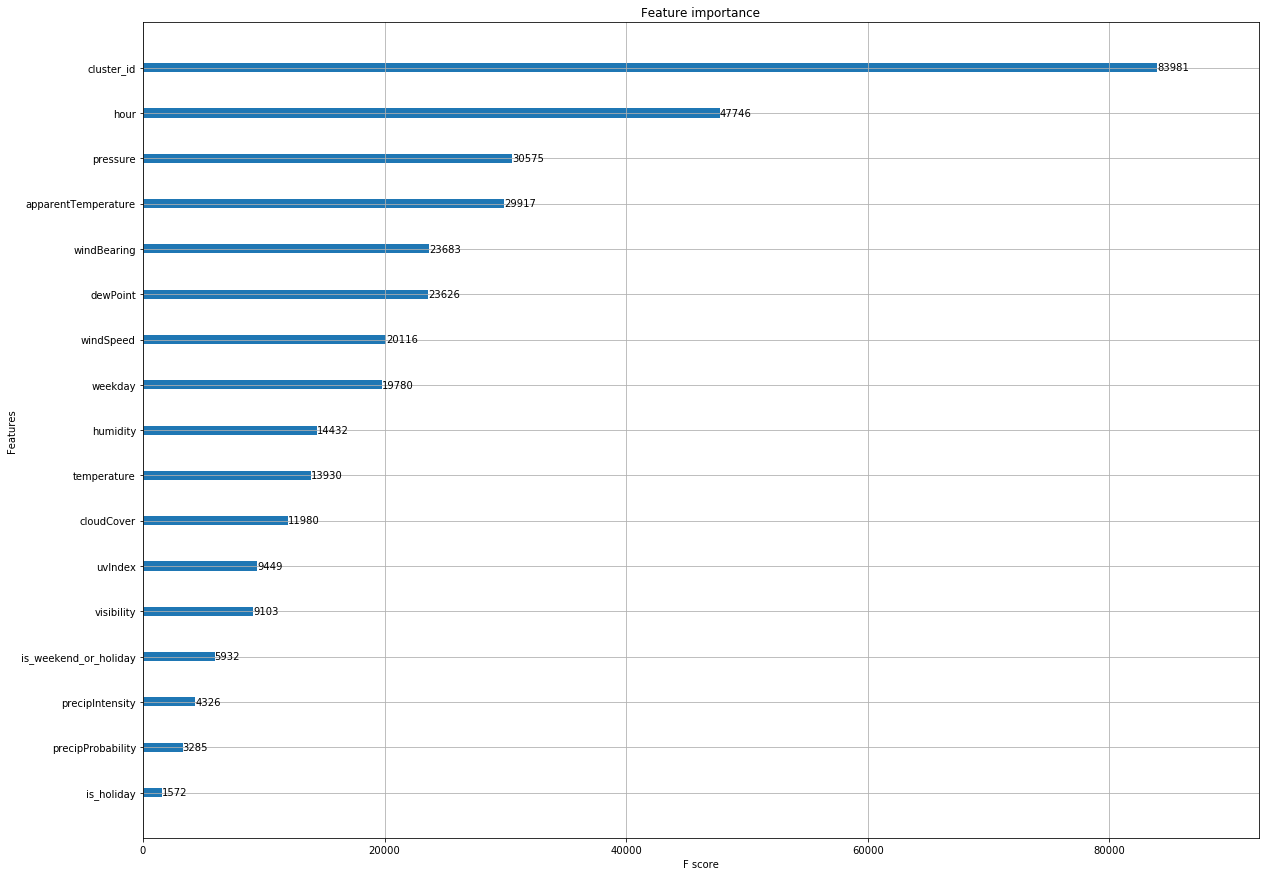

In [16]:
xgb.plot_importance(final_model)